In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

### SR0 S2 Single Scatter Cut check for SR1

In [2]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import UnivariateSpline
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

In [40]:
pax_version = '6.6.5'
sources = ['rn', 'ambe', 'ng']
run_names_path = ['/home/zhut/data/SingleScatter/data/run_names_v%s_%s.pkl' % (pax_version,source) for source in sources]
dsets = pd.concat([pd.read_pickle(path) for path in run_names_path])

your_own_path = ['/home/zhut/data/SingleScatter/data/pickles/pax_v%s_%s_event_combine' % (pax_version,source) for source in sources]
name_list = []
# Check minitree building survival rate / check souce_type composition
for path in your_own_path:
    name_list.extend ([f[:11] for f in os.listdir(path) if '.pkl' in f])
for st in dsets.source__type.unique():
    print ('%s : %d / %d' %(st,
                            len(dsets[(dsets.source__type == st) & (dsets.name.isin(name_list))]),
                            len(dsets[(dsets.source__type == st)])
                           ), end = '  ')

if True:
    # Read from pickled files
    df_copy = []
    for path in your_own_path:
        for i, file in enumerate(os.listdir(path)):
            if '.pkl' in file:
                temp = pd.read_pickle(os.path.join(path,file))
                temp['source__type'] = dsets[dsets.name == file[:11]].source__type.values[0]
                df_copy.append(temp)
            if i > 300: # << loop number control
                break
    df_copy = pd.concat(df_copy)
    print (len(df_copy))

Rn220 : 128 / 138  AmBe : 142 / 268  neutron_generator : 22 / 28  32809


In [43]:
# Define some useful alias and fuctions
def s2_width_up(dt):
    return (0.8 + 0.5/500*dt + np.sqrt((0.7636)**2+0.02301866*dt))*1.349/3.32

def s2_width_low(dt):
    return (-0.4 - 0.5/500*dt + np.sqrt((0.7636)**2+0.02301866*dt))*1.349/3.32

# Put all the plot functions together
def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = True):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title(title)
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = 'Number of entries')
    else:
        pass

In [65]:
diffusion_constant = 2.280000e-08 #pax_config['WaveformSimulator']['diffusion_constant_liquid']
v_drift = 1.440000e-04 #pax_config['DEFAULT']['drift_velocity_liquid']
def s2_width_model(z):
        w0 = 337.3
        return np.sqrt(w0 ** 2 - 5.7370 * diffusion_constant * z / v_drift ** 3)
    
def s2_width_bounds(dt, kind='high'):
    if kind == 'high':
        return (0.8 + 0.5/500*dt)*0.9 + s2_width_model(-dt*v_drift)
    if kind == 'low':
        return (-0.4 - 0.5/500*dt)*0.9 + s2_width_model(-dt*v_drift)
        

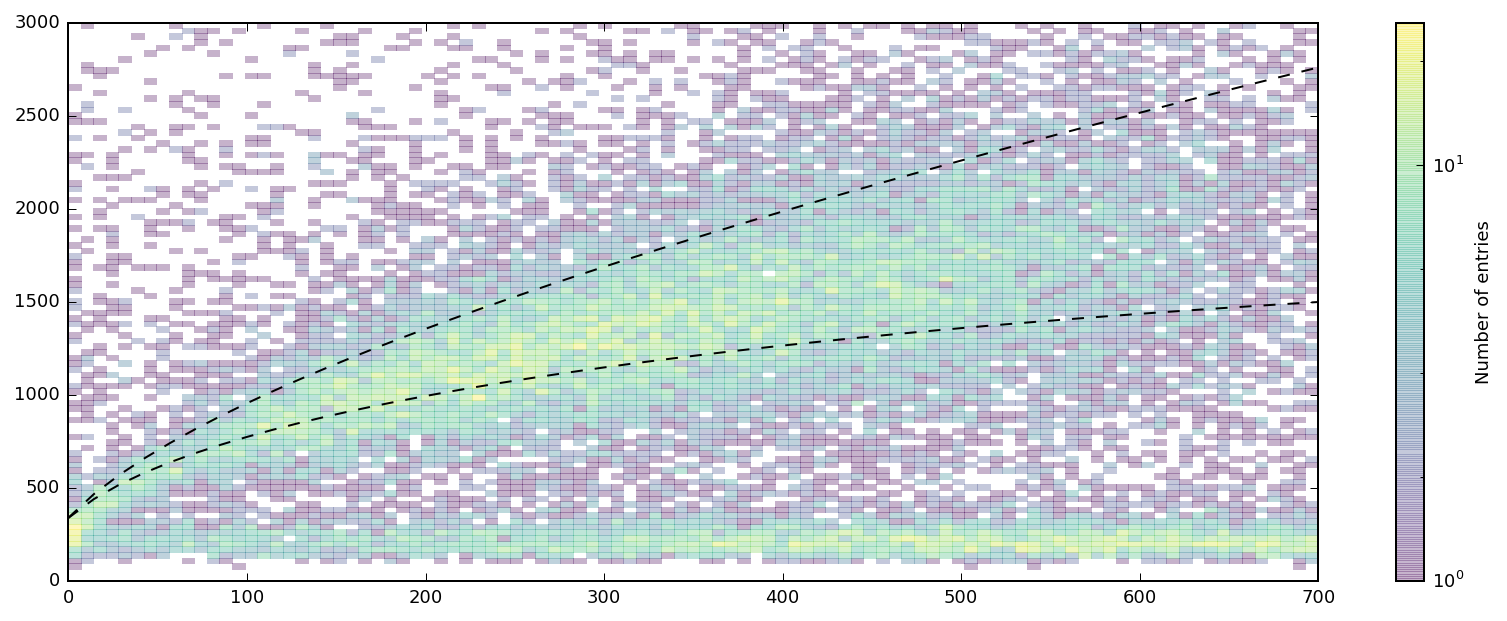

In [75]:
# Width cut check

mh = Histdd(df_copy.s2_1_delay_is1/1e3, df_copy.s2_1_range_50p_area,
           bins = (np.linspace(0,700,100),np.linspace(0,3000,100)))
mh.plot(log_scale=True,cmap=plt.get_cmap('viridis'),alpha = 0.3)

dt = np.linspace(0,700e3)
plt.plot(dt/1e3,s2_width_bounds(dt,'high'),'k--',dt/1e3,s2_width_bounds(dt,'low'),'k--')

plt.show()

In [81]:
# Classification
# define functions that seperate different type of events

sel_ion = lambda df: df[((df.source__type == 'AmBe') | (df.source__type == 'Rn220') | (df.source__type == 'neutron_generator')) &
                        (
                        ( (np.log10(df.s2_1_range_50p_area)>3.85) & #Select large width photo ionization
                        (df.s2_1_delay_is2>0) & (df.s2_1_delay_is1>80e3) )
                        |
                        ( (df.s2_1_delay_is1>750e3) ) #Select small width ones.
                        ) & 
                        (df.s2>s2_0_bounds[0]) & (df.s2<s2_0_bounds[1]) & #Box cuts for plotting
                        (df.s2_1_area>s2_1_bounds[0]) & (df.s2_1_area<s2_1_bounds[1]) #Box cuts for plotting
                       ]
sel_rio = lambda df: df[(df.source__type == 'Rn220') & (df.s2_1_delay_is1>90e3) &
                        (df.s1<200) &
                        (df.s2>s2_0_bounds[0]) & (df.s2<s2_0_bounds[1]) & #Box cuts for plotting
                        (df.s2_1_area>s2_1_bounds[0]) & (df.s2_1_area<s2_1_bounds[1]) #Box cuts for plotting
                       ]
sel_mul = lambda df: df[((df.source__type == 'AmBe') | (df.source__type == 'Rn220') | (df.source__type == 'neutron_generator')) &
                        (df.s2_1_delay_is1>80e3) & (df.s2_1_delay_is1<670e3) &
                        (df.s2_1_range_50p_area>s2_width_bounds(df.s2_1_delay_is1,'low')) & 
                        (df.s2_1_range_50p_area<s2_width_bounds(df.s2_1_delay_is1,'high')) &
                        (np.log10(df.cs2/df.cs1) < np.log10(5000/df.cs1)+8e-4*df.cs1) & #NR band
                        (df.s2>s2_0_bounds[0]) & (df.s2<s2_0_bounds[1]) & #Box cuts for plotting
                        (df.s2_1_area>s2_1_bounds[0]) & (df.s2_1_area<s2_1_bounds[1]) #Box cuts for plotting
                       ]


sel_ambe = lambda df:df[(df.source__type == 'AmBe')|(df.source__type == 'neutron_generator')]
sel_rn220 = lambda df:df[(df.source__type == 'Rn220')]

In [46]:
# define ses2_size_cut
def ses2_size_cut(s2_area):
    linear_0 = s2_area * 0.01 + 90
    linear_1 = s2_area * 0.025 + 766
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 26000) * 6e-4) + 1) 
    fermi_dirac_coef_1 = 1 / (np.exp((26000 - s2_area) * 6e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

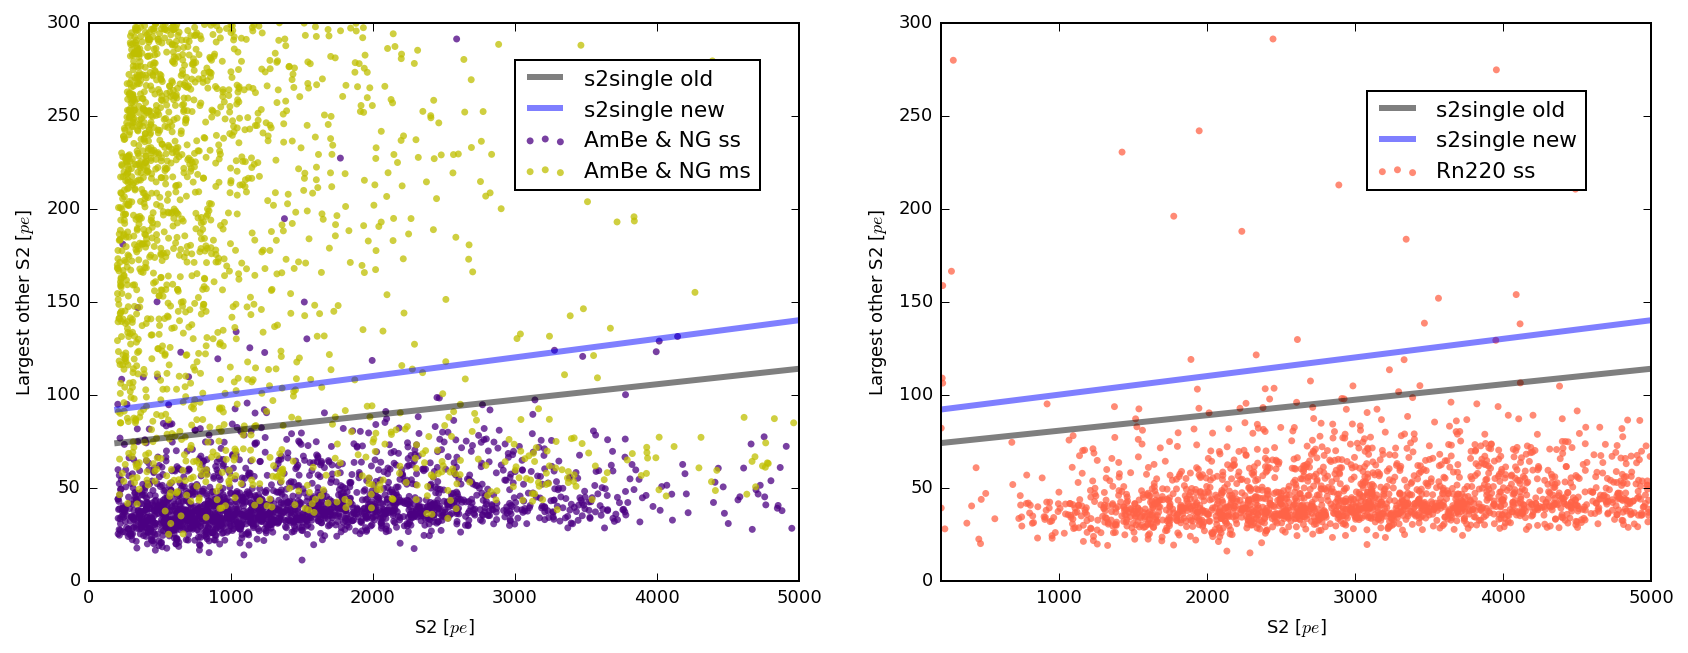

In [82]:
matplotlib.rc('font', size = 9)
plt.rcParams['figure.figsize'] = (14, 5)
fig = plt.figure()

s2_0_bounds, s2_1_bounds = [200,5000], [0,300]
sel_box = lambda df: df[(df.s2_1_area<s2_1_bounds[1]) &
                        (df.s2<s2_0_bounds[1])]

####################1a#####################
ax = fig.add_subplot(121)

df_ = sel_ambe(sel_ion(df_copy))
plt.scatter(df_.s2, df_.s2_1_area,color='indigo',s=12,edgecolor='none', alpha = 0.75)

df_ = sel_ambe(sel_mul(df_copy))
plt.scatter(df_.s2, df_.s2_1_area,color='y',s=12,edgecolor='none', alpha = 0.75)
    
plt_config(title = '', xbounds = [0,5000], ybounds = s2_1_bounds,
           xlabel = 'S2 [$pe$]', ylabel = 'Largest other S2 [$pe$]',colorbar = False, sci = False)

x = np.linspace(s2_0_bounds[0],s2_0_bounds[1],100)
plt.plot(x,ses2_size_cut_ori(x),'k-',lw=3, alpha = 0.5)
plt.plot(x,ses2_size_cut(x),'-b',lw=3, alpha = 0.5)

plt.legend(['s2single old','s2single new','AmBe & NG ss','AmBe & NG ms'],loc=[0.6,0.7])

####################1b#####################
ax = fig.add_subplot(122)

df_ = sel_rio(df_copy)
plt.scatter(df_.s2, df_.s2_1_area,color='tomato',s=12,edgecolor='none',alpha = 0.75)

plt_config(title = '', xbounds = s2_0_bounds, ybounds = s2_1_bounds,
           xlabel = 'S2 [$pe$]', ylabel = 'Largest other S2 [$pe$]',colorbar = False, sci = False)

x = np.linspace(s2_0_bounds[0],s2_0_bounds[1],100)
plt.plot(x,ses2_size_cut_ori(x),'k-',lw=3, alpha = 0.5)
plt.plot(x,ses2_size_cut(x),'-b',lw=3, alpha = 0.5)

plt.legend(['s2single old','s2single new','Rn220 ss'],loc=[0.6,0.7])
###
plt.show()


 ^s2    |  350|  650|  950| 1250| 1550| 1850| 2150| 2450| 2750| 3050| 3350| 3650| 3950| 4250| 4550| 4850| 
 ^values| 0.5714| 1.0000| 0.9512| 0.9750| 0.9758| 0.9609| 0.9758| 0.9651| 0.9657| 0.9787| 0.9487| 0.9855| 0.9716| 0.9912| 0.9789| 0.9901| 
 ^up err| 0.1201| -0.0001| 0.0268| 0.0139| 0.0115| 0.0148| 0.0102| 0.0123| 0.0121| 0.0090| 0.0158| 0.0081| 0.0119| 0.0064| 0.0118| 0.0072| 
 ^low err|0.1261| 0.0784| 0.0417| 0.0222| 0.0167| 0.0196| 0.0141| 0.0159| 0.0156| 0.0124| 0.0196| 0.0131| 0.0164| 0.0128| 0.0188| 0.0144| 
 ^s2    |  350|  650|  950| 1250| 1550| 1850| 2150| 2450| 2750| 3050| 3350| 3650| 3950| 4250| 4550| 4850| 
 ^values| 0.6429| 1.0000| 1.0000| 1.0000| 0.9919| 0.9766| 0.9939| 0.9884| 0.9884| 1.0000| 0.9744| 0.9927| 0.9857| 0.9912| 0.9894| 1.0000| 
 ^up err| 0.1134| -0.0001| -0.0000| -0.0000| 0.0058| 0.0111| 0.0044| 0.0065| 0.0065| -0.0000| 0.0108| 0.0053| 0.0080| 0.0064| 0.0077| -0.0000| 
 ^low err|0.1254| 0.0784| 0.0275| 0.0142| 0.0118| 0.0162| 0.0089| 0.0105| 0.0105| 0.

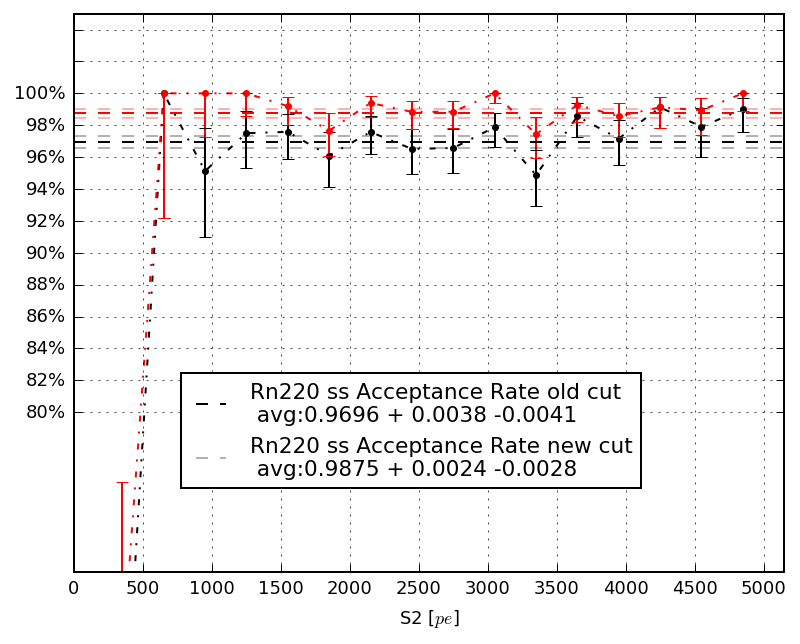


 ^s2    |  350|  650|  950| 1250| 1550| 1850| 2150| 2450| 2750| 3050| 3350| 3650| 3950| 4250| 4550| 4850| 
 ^values| 0.9610| 0.9751| 0.9790| 0.9800| 0.9840| 0.9768| 0.9684| 0.9429| 0.9688| 0.9238| 0.9185| 0.9627| 0.9138| 0.9481| 0.8372| 0.8056| 
 ^up err| 0.0063| 0.0039| 0.0034| 0.0037| 0.0037| 0.0049| 0.0063| 0.0094| 0.0080| 0.0140| 0.0167| 0.0131| 0.0236| 0.0215| 0.0502| 0.0589| 
 ^low err|0.0070| 0.0043| 0.0039| 0.0042| 0.0043| 0.0056| 0.0072| 0.0105| 0.0097| 0.0158| 0.0190| 0.0169| 0.0283| 0.0293| 0.0602| 0.0697| 
 ^s2    |  350|  650|  950| 1250| 1550| 1850| 2150| 2450| 2750| 3050| 3350| 3650| 3950| 4250| 4550| 4850| 
 ^values| 0.9033| 0.8500| 0.7952| 0.7459| 0.7250| 0.6522| 0.6316| 0.3529| 0.5172| 0.2000| 0.2857| 0.3846| 0.2857| 0.3333| 0.1250| 0.0000| 
 ^up err| 0.0122| 0.0185| 0.0267| 0.0376| 0.0473| 0.0548| 0.0610| 0.0672| 0.0889| 0.0772| 0.0871| 0.1303| 0.1221| 0.1811| 0.1387| 0.1328| 
 ^low err|0.0132| 0.0199| 0.0285| 0.0402| 0.0509| 0.0577| 0.0640| 0.0635| 0.0896| 0.0646| 

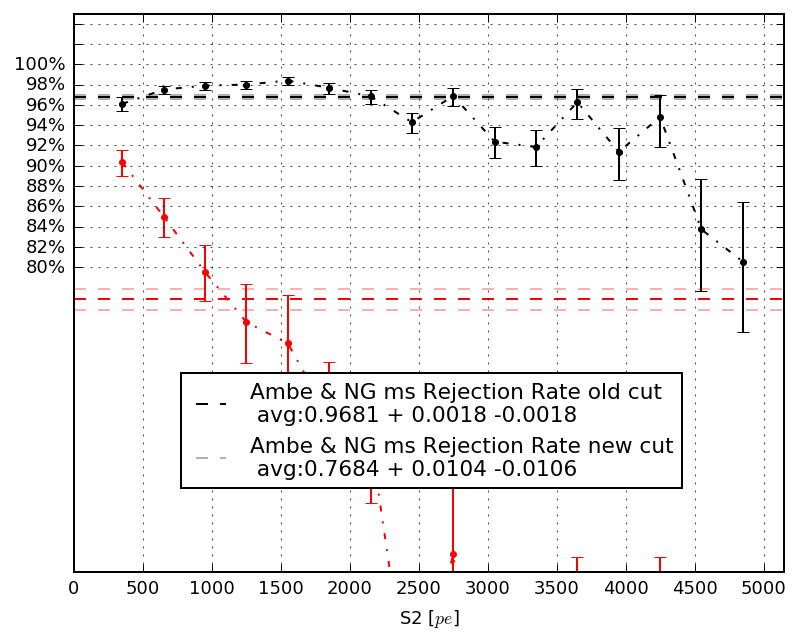

In [84]:
matplotlib.rc('font', size = 9)
plt.rcParams['figure.figsize'] = (14, 5)
fig = plt.figure()
from scipy.stats import beta

def f(x,rv):
    return rv.ppf(rv.cdf(x)+0.68)-x

def error_eff(pha,pht):
    rv = [beta(pha[i]+1,pht[i]-pha[i]+1) for i in range(len(pha[:]))]
    bounds = [(rv[i].ppf(0),rv[i].ppf(0.319)) for i in range(len(pha[:]))]
    low = [pha[i]/pht[i]-minimize(f,0.1,rv[i],bounds=(bounds[i],)).x[0] for i in range(len(pha[:]))]
    high = [f(pha[i]/pht[i]-low[i],rv[i])-low[i] for i in range(len(pha[:]))]
    return low,high

def plot_eff(c,eff_type = 'acc',bias = 0.7,cut = None):
    global s2_0_bounds, s2_1_bounds, dt_bounds, width_bounds
    s2_0_bounds, s2_1_bounds = [200,5000], [0,300]
    if eff_type == 'acc':
        df_['acc'] = 0.5+0.5*(cut(df_.s2)-df_.s2_1_area)/abs(df_.s2_1_area-cut(df_.s2))
    elif eff_type == 'rej':
        df_['acc'] = 0.5+0.5*(df_.s2_1_area-cut(df_.s2))/abs(df_.s2_1_area-cut(df_.s2))
    
    mh = Histdd(df_.s2, df_.acc,
                axis_names=('S2', 'acc'),
                bins=(np.linspace(s2_0_bounds[0], s2_0_bounds[1], 17),
                      np.linspace(-0.5, 1.5, 3)))
    pht= mh.projection(axis=0)
    pha = mh.average(axis=1)
    print('\n ^s2', end = '    | ')
    [ print('%4d' %va,end = '| ') for va in pha.bin_centers[:]]
    print('\n ^values', end = '| ')
    [ print('%.4f' %va,end = '| ') for va in pha[:]]
    
    
    pha[:] *= pht[:]
    
    low,high = error_eff(pha,pht)
    print('\n ^up err', end = '| ')
    [ print('%.4f' %va,end = '| ') for va in high[:]]
    print('\n ^low err', end = '|')
    [ print('%.4f' %va,end = '| ') for va in low[:]]
    plt.errorbar(pht.bin_centers,pha[:]/pht[:]-bias,yerr=[low,high],fmt='.',color=c,ls='-.',capsize=3.)
    plot_options = {'xmin':0,'xmax':1,'color':c, 'ls':'--', 'lw':1.}
    plt.axhline(y=np.average(df_.acc)-bias, **plot_options)
    low,high = error_eff([sum(pha[:])],[sum(pht[:])])
    plt.axhline(y=np.average(df_.acc)-bias-low, alpha =0.3,**plot_options)
    plt.axhline(y=np.average(df_.acc)-bias+high, alpha =0.3,**plot_options)
    
    #print ('%d,%d,%d' %(np.average(df_.acc),low,high))
    return np.average(df_.acc), low, high

labels = ['%d%%'%(i*2+80) for i in range(11)]

########################_efficiency plots_########################
fig = plt.figure()
ax = fig.add_subplot(121)

s2_0_bounds, s2_1_bounds = [200,5000], [0,5e3]
df_ = sel_rio(df_copy)
acc_old, low, high = plot_eff('k',eff_type ='acc',bias = 0.7,cut = ses2_size_cut_ori)
low_o, high_o = low[0], high[0]
#
#plt.legend(['Rn220 ss Acceptance Rate \n avg:%.4f + %.4f -%.4f'%(acc_old,high,low)],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)

plt.xticks(np.asarray([i*500 for i in range(11)]),color='k')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(16)]),labels,color='k')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)

df_ = sel_rio(df_copy)
acc_new, low, high = plot_eff('r',eff_type ='acc',bias = 0.7,cut = ses2_size_cut)
low, high = low[0], high[0]

plt.legend(['Rn220 ss Acceptance Rate old cut\n avg:%.4f + %.4f -%.4f'%(acc_old,high_o,low_o),
            'Rn220 ss Acceptance Rate new cut\n avg:%.4f + %.4f -%.4f'%(acc_new,high,low),
           ],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)

plt.show()

########################_efficiency plots_########################
fig = plt.figure()
ax = fig.add_subplot(122)

s2_0_bounds, s2_1_bounds = [200,5000], [0,5.0e3]
df_ = sel_ambe(sel_mul(df_copy))
acc_old, low, high = plot_eff('k',eff_type ='rej',bias = 0.7,cut = ses2_size_cut_ori)
low_o, high_o = low[0], high[0]
#
#plt.legend(['Rn220 ss Acceptance Rate \n avg:%.4f + %.4f -%.4f'%(acc_old,high,low)],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)

plt.xticks(np.asarray([i*500 for i in range(11)]),color='k')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(16)]),labels,color='k')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)

df_ = sel_ambe(sel_mul(df_copy))
acc_new, low, high = plot_eff('r',eff_type ='rej',bias = 0.7,cut = ses2_size_cut)
low, high = low[0], high[0]

plt.legend(['Ambe & NG ms Rejection Rate old cut\n avg:%.4f + %.4f -%.4f'%(acc_old,high_o,low_o),
            'Ambe & NG ms Rejection Rate new cut\n avg:%.4f + %.4f -%.4f'%(acc_new,high,low),
           ],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [-0.2,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)

plt.show()

if False:"""
#####################################################################
fig = plt.figure()
ax = fig.add_subplot(121)
s2_0_bounds, s2_1_bounds = [200,5000], [0,5.0e3]
df_ = sel_ambe(sel_mul(df_copy))
rej_new, low, high = plot_eff('r',eff_type ='rej',bias = 0.7,cut = ses2_size_cut)
low, high = low[0], high[0]
plt.legend(['AmBe ms Rejection Rate (%.4f) new'%rej_new,
            'AmBe ms Rejection Rate (%.4f) old'%rej_old],loc=[0.15,0.25])
#plt.legend(['AmBe ms Rejection Rate \n avg:%.4f + %.4f -%.4f'%(rej_new,high,low)],loc=[0.15,0.15])

plt_config(title = '', xbounds = [0,5150], ybounds = [0,0.35],
           xlabel = 'S2 [$pe$]', ylabel = '',colorbar = False, sci = False)
plt.xticks(np.asarray([i*500 for i in range(11)]),color='r')
plt.yticks(np.asarray([i*0.02+0.1 for i in range(11)]),labels,color='r')
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)
plt.show()"""
########### End ################
del df_